In [34]:
!pip install -q tensorflow-gpu==2.0.0-rc1

In [35]:
import tensorflow as tf

In [36]:
!pip install -q imageio
# GIF 이미지 생성용

In [37]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [38]:
(train_images, train_labels), (_,_) = tf.keras.datasets.fashion_mnist.load_data()

In [39]:
train_images.shape
train_images

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [40]:
train_images = train_images.reshape(train_images.shape[0], 28,28,1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1] 로 정규화

In [41]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [42]:
# 데이터 배치를 만들고 섞는다
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [43]:
# 생성자는 시드값으로 부터 이미지를 생성하기 위해, tf.keras.layers.Conv2Dtranspose(업샘플링)층을 이용
# 처음 Dense 층은 이 시드값을 인풋으로 받는다.
# 그다음 원하는 사이즈 28* 28*1 의 이미지가 나오도록 업샘플링을 여러번 한다.
# tanh를 사용하는 마지막 층을 제외한 나머지 각 층마다 활성함수로 LeakyRelu를 사용한다.

In [44]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None, 7,7,256) # 배치사이즈로는 None이 주어진다.

  model.add(layers.Conv2DTranspose(128,(5,5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None,28,28,1)

  return model

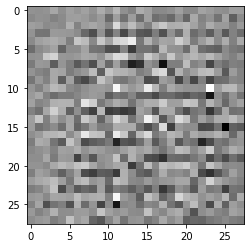

In [45]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [46]:
# 감별자 , 감별자는 합성곱 신경망(CNN) 기반의 이미지 분류기 이다.

In [47]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model

In [48]:
# (아직까지 훈련이 되지 않은) 감별자를 사용하여, 생성된 이미지가 진짜인지 가짜인지 판별한다.
# 모델은 진짜 이미지에는 양수의 값을 가짜 이미지에는 음수 값을 출력하도록 훈련되어진다.

In [49]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00404574]], shape=(1, 1), dtype=float32)


In [50]:
#손실함수와 옵티마이저 정의
# 크로스 엔트로피 손실함수(cross entropy loss)를 계산하기 위해 (helper) 함수를 반환한다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [51]:
# 감별자 손실함수
# 이 메서는 감별자가 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는지 수치화 한다.
# 진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬을 비교하고, 가짜(생성된)이미지에 대한 감별자의 예측과 0 으로 이루어진 행렬을 비교


In [52]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [53]:
# 생성자 손실함수
# 생성자의 손실함수는 감별자를 얼마나 잘 속였는지에 대해 수치화 합니다.
# 직관적으로 생성자가 원활히 수행되고 있다면, 감별자는 가짜 이미지를 진짜(또는 1)로 분류할것입니다.
# 여기서 우리는 생성된 이미지에 대한 감별자의 결정을 1로 이루어진 행렬과 비교할 것입니다.


In [54]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output) 

In [55]:
# 감별자와 생성자는 따로 훈련되기 때문에, 감별자와 생성자의 옵티마이저는 다릅니다.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [56]:
#체크포인트 저장
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer= discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [57]:
# 훈련 루프 정의
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [58]:
# 훈련 루프는 생성자가 입력으로 랜던시드를 받는 것으로 부터 시작된다.
# 그 시드값을 사용하여 이미지를 생성한다. 감별자를 사용하여 (훈련 세트에서 갖고온) 진짜 이미지와
#(생성자가 생성해낸) 가짜 이미지를 분류한다. 각 모델의 손실을 계산하고, 그래디언트를 사용해 생성자와 감별자를 업데이트한다.

In [59]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_image = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_image, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [60]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    #GIF 를 위한 이미지를 바로 생성
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch +1,seed)

    if (epoch +1) % 30 == 0: # 에퐄 30번 마다 모델 저장
      checkpoint.save(file_prefix = checkpoint_prefix)
  
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)



In [61]:
# 이미지 생성 및 저장
def generate_and_save_images(model, epoch, test_input):
  # training 이 False 로 맞춰진것에 주목
  # 이렇게 하면 (배치 정규화를 포함하여) 모든 층들이 추론 모드로 실행된다.

  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

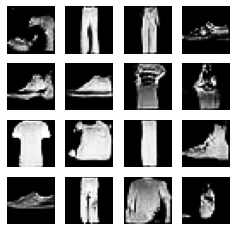

CPU times: user 13min 14s, sys: 2min 10s, total: 15min 25s
Wall time: 56min 33s


In [62]:
%%time
train(train_dataset, EPOCHS)

In [63]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [64]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

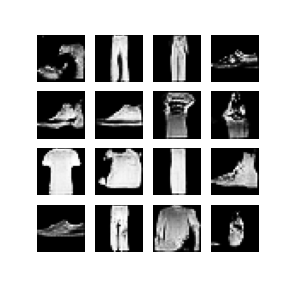

In [65]:
display_image(EPOCHS)

In [66]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)